In [1]:
import os
from time import time
import multiprocessing
import netCDF4 as nc
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from trs import *

In [2]:
subset = xr.open_mfdataset('data/raw/range-2020-01-*.nc',combine='by_coords')

In [3]:
subset.zos.shape

(2976, 1037, 463)

In [4]:
coarse = subset.zos.values[:,::2,::2]
latitude = subset.lat.values[::2]
longitude = subset.lon.values[::2]

In [6]:
coarse.shape

(2976, 519, 232)

In [7]:
coarse = xr.Dataset({
    'z': xr.DataArray(
        data=coarse,
        coords={'time': subset.time.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','lat','lon'])})
        
        
# coarse.to_netcdf(path=f'data/processed/range-coarse-2020-01.nc')
    

In [49]:
coarse_subset = xr.open_dataset('data/processed/range-coarse-2020-01.nc')

In [5]:
coarse_subset.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 2976, lat: 519, lon: 232)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:45:00
  * lat      (lat) float32 48.0 48.03 48.05 48.08 ... 61.92 61.95 61.97 62.0
  * lon      (lon) float32 -10.0 -9.939 -9.879 -9.818 ... 3.818 3.879 3.939 4.0
Data variables:
    z        (time, lat, lon) float32 ...>

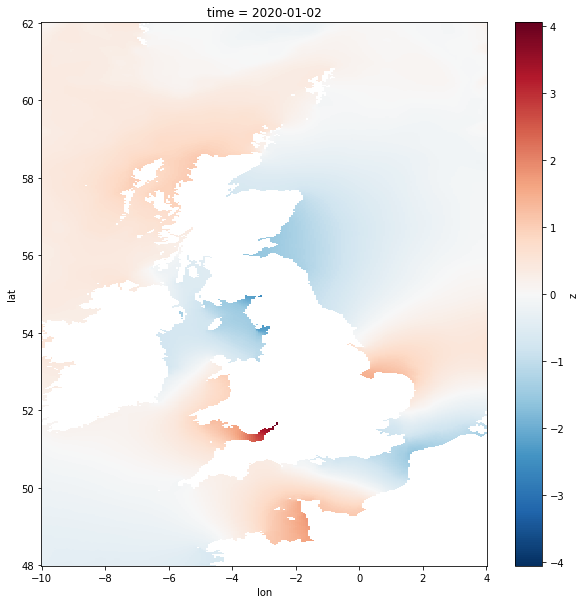

In [5]:
target_time = '2020-01-02T00:00:00.000000000' 
coarse_subset.z.sel(time=target_time,method='nearest').plot(size=10,aspect=1)  

In [39]:
ds = xr.open_dataset('data/processed/stream-pd.nc')

In [7]:
coarse = ds.pd.values[:,:,::2,::2]
latitude = ds.lat.values[::2]
longitude = ds.lon.values[::2]

In [8]:
coarse.shape

(672, 1, 519, 232)

In [14]:
coarse = xr.Dataset({
    'pd': xr.DataArray(
        data=coarse,
        coords={'time': ds.time.values,
                'depth': ds.depth.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','depth','lat','lon'])})
        
        
# coarse.to_netcdf(path=f'data/processed/stream-coarse-pd.nc')
    

In [15]:
coarse_ds = xr.open_dataset('data/processed/stream-coarse-pd.nc')

In [18]:
coarse_ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:  (time: 672, depth: 1, lat: 519, lon: 232)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02 ... 2020-01-29T23:00:00
  * depth    (depth) float32 20.0
  * lat      (lat) float32 48.0 48.03 48.05 48.08 ... 61.92 61.95 61.97 62.0
  * lon      (lon) float32 -10.0 -9.939 -9.879 -9.818 ... 3.818 3.879 3.939 4.0
Data variables:
    pd       (time, depth, lat, lon) float32 ...>

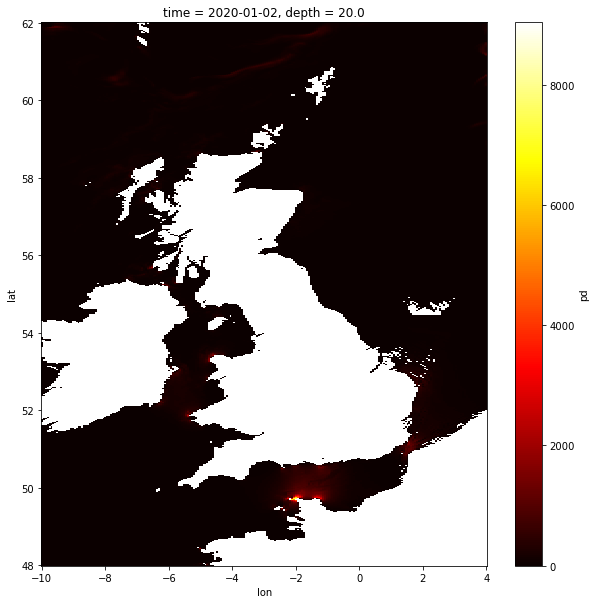

In [17]:
target_time = '2020-01-02T00:00:00.000000000' 
coarse_ds.pd.sel(time=target_time,method='nearest').plot(size=10,aspect=1,cmap='hot')  

In [20]:
uk = coarse_subset.z.sel(time=target_time,method='nearest').values
latitude = coarse_subset.lat.values
longitude = coarse_subset.lon.values

for j in range(len(latitude)):
    for k in range(len(longitude)):
        if np.isnan(uk[j,k]) == True:
            pass
        else:
            uk[j,k] = 0
        
        

In [21]:
pd = coarse_ds.pd.values
pd.shape

(672, 1, 519, 232)

In [22]:
uk.shape

(519, 232)

In [25]:
for j in range(len(latitude)):
    for k in range(len(longitude)):
        
        if uk[j,k] == 0 and np.isnan(pd[0,0,j,k]) == True:
            pd[:,:,j,k] = -5
            

In [26]:
coarse = xr.Dataset({
    'pd': xr.DataArray(
        data=pd,
        coords={'time': ds.time.values,
                'depth': ds.depth.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','depth','lat','lon'])})
        
        
# coarse.to_netcdf(path=f'data/processed/stream-coarse-pd2.nc')

In [27]:
coarse_ds = xr.open_dataset('data/processed/stream-coarse-pd2.nc')

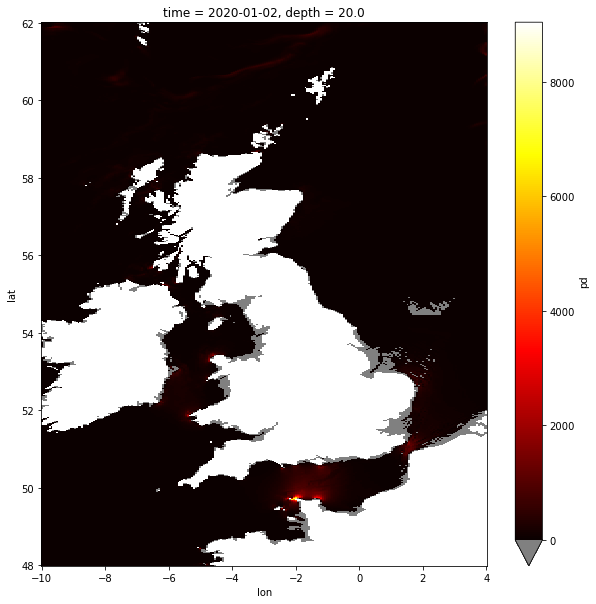

In [29]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')

target_time = '2020-01-02T00:00:00.000000000' 
coarse_ds.pd.sel(time=target_time,method='nearest').plot(size=10,aspect=1,vmin=0,cmap=cmap)  

In [41]:
stream_combined = xr.open_dataset('data/raw/stream-2020-01.nc')

In [42]:
stream_combined = stream_combined.assign(speed=lambda stream_combined: 
                                         np.sqrt((stream_combined.uo)**2 + (stream_combined.vo)**2))



rho = 1025 # sea water density
A = 1
Cp = 1

stream_combined = stream_combined.assign(pd=lambda stream_combined: 0.5*Cp*rho*A*(stream_combined.speed**3))

In [43]:
subset = stream_combined[['pd']].sel(time=slice('2020-01-02','2020-01-30T00:00:00.000000000'))

In [44]:
subset.time

<xarray.DataArray 'time' (time: 673)>
array(['2020-01-02T00:00:00.000000000', '2020-01-02T01:00:00.000000000',
       '2020-01-02T02:00:00.000000000', ..., '2020-01-29T22:00:00.000000000',
       '2020-01-29T23:00:00.000000000', '2020-01-30T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02 2020-01-02T01:00:00 ... 2020-01-30
Attributes:
    axis:                 T
    standard_name:        time
    long_name:            Validity time
    _ChunkSizes:          512
    _CoordinateAxisType:  Time
    valid_min:            1577836800.0
    valid_max:            1580511600.0

In [45]:
coarse = subset.pd.values[:,:,::2,::2]
latitude = subset.lat.values[::2]
longitude = subset.lon.values[::2]

In [46]:
coarse.shape

(673, 1, 519, 232)

In [47]:
coarse = xr.Dataset({
    'pd': xr.DataArray(
        data=coarse,
        coords={'time': subset.time.values,
                'depth': subset.depth.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','depth','lat','lon'])})
        
        
coarse.to_netcdf(path=f'data/processed/stream-coarse-pd-3.nc')
    

In [48]:
coarse_ds = xr.open_dataset('data/processed/stream-coarse-pd-3.nc')

In [50]:
uk = coarse_subset.z.sel(time=target_time,method='nearest').values
latitude = coarse_subset.lat.values
longitude = coarse_subset.lon.values

for j in range(len(latitude)):
    for k in range(len(longitude)):
        if np.isnan(uk[j,k]) == True:
            pass
        else:
            uk[j,k] = 0

In [51]:
pd = coarse_ds.pd.values
pd.shape

(673, 1, 519, 232)

In [52]:
for j in range(len(latitude)):
    for k in range(len(longitude)):
        
        if uk[j,k] == 0 and np.isnan(pd[0,0,j,k]) == True:
            pd[:,:,j,k] = -5
            

In [53]:
coarse = xr.Dataset({
    'pd': xr.DataArray(
        data=pd,
        coords={'time': coarse_ds.time.values,
                'depth': coarse_ds.depth.values,
                'lat': latitude,
                'lon': longitude},
        dims=['time','depth','lat','lon'])})
        
        
coarse.to_netcdf(path=f'data/processed/stream-coarse-pd4.nc')

In [59]:
ds = xr.open_dataset('data/processed/stream-coarse-pd4.nc')

In [60]:
ds

<xarray.Dataset>
Dimensions:  (time: 673, depth: 1, lat: 519, lon: 232)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-02 2020-01-02T01:00:00 ... 2020-01-30
  * depth    (depth) float32 20.0
  * lat      (lat) float32 48.0 48.03 48.05 48.08 ... 61.92 61.95 61.97 62.0
  * lon      (lon) float32 -10.0 -9.939 -9.879 -9.818 ... 3.818 3.879 3.939 4.0
Data variables:
    pd       (time, depth, lat, lon) float32 ...

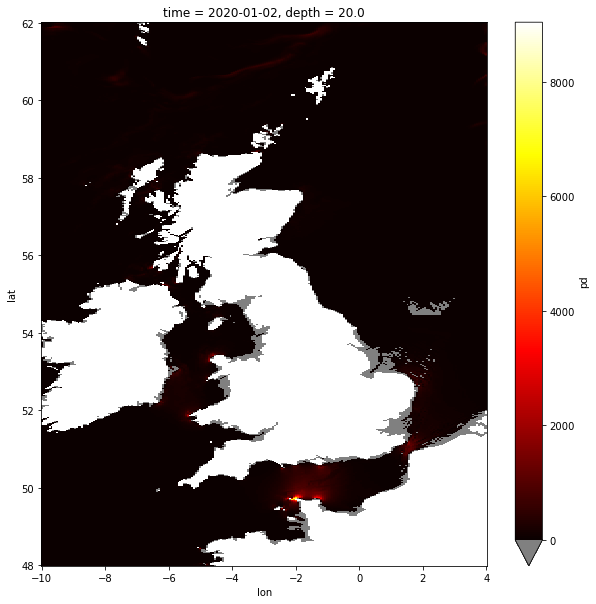

In [61]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('gray')

target_time = '2020-01-02T00:00:00.000000000' 
ds.pd.sel(time=target_time,method='nearest').plot(size=10,aspect=1,vmin=0,cmap=cmap)  

In [62]:
ds['pd'] = ds.pd.assign_attrs(units='$Wm^{-2}$')
ds['pd'] = ds.pd.assign_attrs(long_name='power density')
ds['lat'] = ds.lat.assign_attrs(units='degrees')
ds['lat'] = ds.lat.assign_attrs(long_name='latitude')
ds['lon'] = ds.lon.assign_attrs(units='degrees')
ds['lon'] = ds.lon.assign_attrs(long_name='longitude')
ds['depth'] = ds.depth.assign_attrs(units='m')

In [63]:
ds.to_netcdf(path=f'data/processed/stream-coarse-pd4-1.nc')

In [17]:
ds = xr.open_dataset('data/processed/stream-coarse-pd4-1.nc')

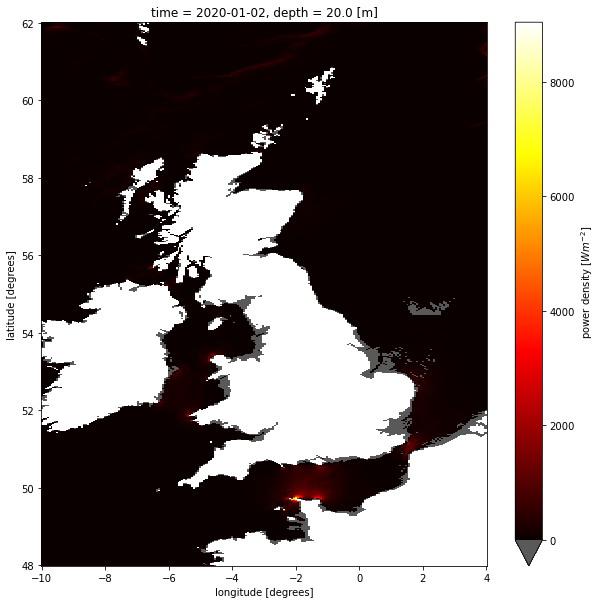

In [18]:
cmap = mpl.cm.get_cmap('hot').copy()
cmap.set_under('#595959')

target_time = '2020-01-02T00:00:00.000000000' 
ds.pd.sel(time=target_time,method='nearest').plot(size=10,aspect=1,vmin=0,cmap=cmap)  

In [20]:
longitude

array([-1.0000000e+01, -9.9393940e+00, -9.8787880e+00, -9.8181820e+00,
       -9.7575760e+00, -9.6969700e+00, -9.6363630e+00, -9.5757570e+00,
       -9.5151510e+00, -9.4545450e+00, -9.3939390e+00, -9.3333330e+00,
       -9.2727270e+00, -9.2121210e+00, -9.1515150e+00, -9.0909090e+00,
       -9.0303030e+00, -8.9696970e+00, -8.9090910e+00, -8.8484850e+00,
       -8.7878790e+00, -8.7272720e+00, -8.6666660e+00, -8.6060600e+00,
       -8.5454540e+00, -8.4848480e+00, -8.4242420e+00, -8.3636360e+00,
       -8.3030300e+00, -8.2424240e+00, -8.1818180e+00, -8.1212120e+00,
       -8.0606060e+00, -8.0000000e+00, -7.9393940e+00, -7.8787880e+00,
       -7.8181820e+00, -7.7575760e+00, -7.6969700e+00, -7.6363640e+00,
       -7.5757580e+00, -7.5151510e+00, -7.4545450e+00, -7.3939390e+00,
       -7.3333330e+00, -7.2727270e+00, -7.2121210e+00, -7.1515150e+00,
       -7.0909090e+00, -7.0303030e+00, -6.9696970e+00, -6.9090910e+00,
       -6.8484850e+00, -6.7878790e+00, -6.7272730e+00, -6.6666670e+00,
      

In [21]:
latitude

array([48.     , 48.02703, 48.05405, 48.08108, 48.10811, 48.13514,
       48.16216, 48.18919, 48.21622, 48.24324, 48.27027, 48.2973 ,
       48.32433, 48.35135, 48.37838, 48.40541, 48.43243, 48.45946,
       48.48649, 48.51352, 48.54054, 48.56757, 48.59459, 48.62162,
       48.64865, 48.67567, 48.7027 , 48.72973, 48.75676, 48.78378,
       48.81081, 48.83784, 48.86486, 48.89189, 48.91892, 48.94595,
       48.97297, 49.     , 49.02703, 49.05405, 49.08108, 49.10811,
       49.13514, 49.16216, 49.18919, 49.21622, 49.24324, 49.27027,
       49.2973 , 49.32433, 49.35135, 49.37838, 49.40541, 49.43243,
       49.45946, 49.48649, 49.51352, 49.54054, 49.56757, 49.59459,
       49.62162, 49.64865, 49.67567, 49.7027 , 49.72973, 49.75676,
       49.78378, 49.81081, 49.83784, 49.86486, 49.89189, 49.91892,
       49.94595, 49.97297, 50.     , 50.02703, 50.05405, 50.08108,
       50.10811, 50.13514, 50.16216, 50.18919, 50.21622, 50.24324,
       50.27027, 50.2973 , 50.32433, 50.35135, 50.37838, 50.40